<font size = 6>Automatically Exercised Parisian Options’ Pricing and Hedging Strategies - Monte Carlo and Greeks</font>
<font size = 4><div style="text-align: right"> Contributor: Haochen Jiang</div></font>
<font size = 4><div style="text-align: right"> May 8, 2021</div></font>

In [4]:
import psutil as ps
import time

print("PC Physical CPU Number : {}.".format(ps.cpu_count()))
print("PC Logical CPU Number : {}.".format(ps.cpu_count(logical=False)))
print("PC Total Memory : {} bytes.".format(ps.virtual_memory().total))
print("PC Used Memory : {} bytes.".format(ps.virtual_memory().used))
print("PC Used Memory Accounts for : {}%.".format(ps.virtual_memory().percent))

PC Physical CPU Number : 32.
PC Logical CPU Number : 8.
PC Total Memory : 269763182592 bytes.
PC Used Memory : 18869809152 bytes.
PC Used Memory Accounts for : 7.7%.


In [5]:
! pip install sobol_seq
! pip install ghalton

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [3]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sobol_seq
import pandas as pd
from decimal import Decimal
import ghalton

## Normal Distribution Sequence Generating Fuctions

In [4]:
def Box_Muller(x):
    if x.ndim == 1:
        y = np.random.rand(x.shape[0])
    elif x.ndim == 2:
        y = np.random.rand(x.shape[0], x.shape[1])
    else:
        raise ValueError("Input Error: ndim is out of range!")
    return (-2 * np.log(x)) ** 0.5 * np.cos(2 * np.pi * y)


def quasi_seq_uniform_to_randomized_std_normal(x):
    if x.ndim == 1:
        y = np.random.rand(x.shape[0])
    elif x.ndim == 2:
        y = np.random.rand(x.shape[0], x.shape[1])
    else:
        raise ValueError("Input Error: ndim is out of range!")
    return Box_Muller(np.mod(x + y, 1))

## Brownian Motion Paths Iteration Fuctions

In [5]:
def S_iteration(epsilon_matrix, M, N, dt, mu, sigma, S0):
    if type(epsilon_matrix) != np.ndarray:
        raise ValueError("Input Error: type of epsilon_matrix must be numpy.ndarray!")
    if epsilon_matrix.shape != (N, M):
        raise ValueError("Input Error: epsilon_matrix does NOT match M and N!")
    coefficient_matrix_tmp = np.insert(
        epsilon_matrix * sigma * np.sqrt(dt) + 1 + mu * dt, 0, values=1, axis=0
    )
    coefficient_matrix = coefficient_matrix_tmp.cumprod(axis=0)
    stock_price_paths_S = S0 * coefficient_matrix
    mean_S = stock_price_paths_S.mean(axis=1)
    final_S = stock_price_paths_S[-1, :]
    return (stock_price_paths_S, mean_S, final_S)

In [6]:
def lnS_iteration(epsilon_matrix, M, N, dt, mu, sigma, S0):
    if type(epsilon_matrix) != np.ndarray:
        raise ValueError("Input Error: type of epsilon_matrix must be numpy.ndarray!")
    if epsilon_matrix.shape != (N, M):
        raise ValueError("Input Error: epsilon_matrix does NOT match M and N!")
    epsilon_coefficient = epsilon_matrix.cumsum(axis=0) * sigma * np.sqrt(dt)
    constant_matrix = np.ones((N, M)).cumsum(axis=0)
    constant_coefficient = constant_matrix * dt * (mu - 0.5 * sigma ** 2)
    coefficient_matrix = np.insert(
        np.exp(epsilon_coefficient + constant_coefficient), 0, values=1, axis=0
    )
    stock_price_paths_lnS = S0 * coefficient_matrix
    mean_lnS = stock_price_paths_lnS.mean(axis=1)
    final_lnS = stock_price_paths_lnS[-1, :]
    return (stock_price_paths_lnS, mean_lnS, final_lnS)

## Vanilla Option Related Fucitons

In [7]:
def analytic_vanilla(cp_flag, S0_vec, K, T, r, sigma, q=0.0):
    N = norm.cdf
    n = norm.pdf
    d1 = (np.log(S0_vec / K) + (r - q + sigma ** 2 / 2.0) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if cp_flag == "call":
        V = S0_vec * np.exp(-q * T) * N(d1) - K * np.exp(-r * T) * N(d2)
    else:
        V = K * np.exp(-r * T) * N(-d2) - S0_vec * np.exp(-q * T) * N(-d1)
    return V


def analytic_vanilla_delta(cp_flag, S0_vec, K, T, r, sigma, q=0.0):
    N = norm.cdf
    n = norm.pdf
    d1 = (np.log(S0_vec / K) + (r - q + sigma ** 2 / 2.0) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if cp_flag == "call":
        delta = np.exp(-q * T) * N(d1)
    else:
        delta = np.exp(-q * T) * (N(d1) - 1)
    return delta


def analytic_vanilla_gamma(cp_flag, S0_vec, K, T, r, sigma, q=0.0):
    N = norm.cdf
    n = norm.pdf
    d1 = (np.log(S0_vec / K) + (r - q + sigma ** 2 / 2.0) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if cp_flag == "call":
        gamma = (
            np.exp(-(d1 ** 2) / 2)
            / np.sqrt(2 * np.pi)
            * np.exp(-q * T)
            / (S0_vec * sigma * np.sqrt(T))
        )
    else:
        gamma = (
            np.exp(-(d1 ** 2) / 2)
            / np.sqrt(2 * np.pi)
            * np.exp(-q * T)
            / (S0_vec * sigma * np.sqrt(T))
        )
    return gamma

In [8]:
def mc_vanilla(
    cp_flag,
    M,
    T,
    K,
    mu,
    sigma,
    S0_vec,
    art="n",
    quasi="n",
    skip=0,
    randomize="n",
    sampling_method="direct",
):

    if sampling_method == "direct":
        pass
    else:
        raise ValueError(
            "Input Error: Incorrect passed parameter sampling_method! "
            + "Sampling_method of fuction mc_vanilla can only be direct"
        )

    if quasi == "y":
        quasi_epsilon_vec = sobol_seq.i4_sobol_generate(1, M, skip)
    elif quasi == "n":
        pass
    else:
        raise ValueError("Input Error: Incorrect passed parameter quasi!")

    if art == "y":
        stock_price_paths_vec_art = {}
    elif art == "n":
        pass
    else:
        raise ValueError("Input Error: Incorrect passed parameter art!")

    result_vec = []
    stock_price_paths_vec = {}
    if art == "y":
        stock_price_paths_vec_art = {}

    for S0 in S0_vec:
        if quasi == "y":
            if randomize == "y":
                epsilon_vec = quasi_seq_uniform_to_randomized_std_normal(
                    quasi_epsilon_vec
                )
            elif randomize == "n":
                epsilon_vec = Box_Muller(quasi_epsilon_vec)
            else:
                raise ValueError("Input Error: Incorrect passed parameter randomize!")
        else:
            epsilon_vec = np.random.normal(0, 1, (M, 1))
        if art == "y":
            stock_price_paths_vec_art[S0] = S0 * np.exp(
                (mu - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * (-epsilon_vec)
            )
        stock_price_paths_vec[S0] = S0 * np.exp(
            (mu - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * epsilon_vec
        )

    stock_price_paths_vec = [stock_price_paths_vec]
    if art == "y":
        stock_price_paths_vec.append(stock_price_paths_vec_art)

    for i in range(len(stock_price_paths_vec)):
        end_price = pd.DataFrame(np.zeros((M, S0_vec.shape[0])), columns=S0_vec)
        for j in range(S0_vec.shape[0]):
            end_price.iloc[:, j] = stock_price_paths_vec[i][S0_vec[j]]

        discount = np.exp(
            -mu * pd.DataFrame(np.ones((M, S0_vec.shape[0])), columns=S0_vec) * T
        )
        if cp_flag == "call":
            end_value = (
                pd.DataFrame(np.where(end_price > K, end_price - K, 0), columns=S0_vec)
                * discount
            )
        elif cp_flag == "put":
            end_value = (
                pd.DataFrame(np.where(K > end_price, K - end_price, 0), columns=S0_vec)
                * discount
            )
        result_vec.append(end_value.mean(axis=0))

    return (result_vec[0] + result_vec[1]) / 2 if art == "y" else result_vec[0]

## Fitting Fuctions

In [9]:
def polyfit(fitting_y, deg, fitting_x=None):
    if fitting_x == None:
        fitting_x = list(fitting_y.index)
    fitting_coefficient = np.polyfit(list(fitting_y.index), fitting_y, deg)
    fitting_result = np.polyval(fitting_coefficient, fitting_x)
    return pd.DataFrame(fitting_result, index=fitting_x)

In [10]:
def expfit(fitting_y, deg, fitting_x=None):
    if fitting_x == None:
        fitting_x = list(fitting_y.index)
    fitting_coefficient = np.polyfit(list(fitting_y.index), np.log(fitting_y), deg)
    fitting_result = np.polyval(fitting_coefficient, fitting_x)
    return pd.DataFrame(np.exp(fitting_result), index=fitting_x)

## Greeks Difference Fucitons

In [11]:
def delta(pricing_vec):
    delta_vec = (pricing_vec.shift(-1) - pricing_vec.shift(1)).dropna() / (
        pricing_vec.index[2] - pricing_vec.index[0]
    )
    return delta_vec


def gamma(pricing_vec):
    gamma_vec = (
        (pricing_vec.shift(-1) + pricing_vec.shift(1) - 2 * pricing_vec).dropna()
        / (pricing_vec.index[1] - pricing_vec.index[0]) ** 2
        / 2
    )
    return gamma_vec

## ART Analysis Fuctions

In [12]:
def art_effeciency_analysis(F1, F2, S0_vec):
    corr_vec = {}
    estimate1_vec = {}
    estimate2_vec = {}
    estimate_vec = {}
    for i in S0_vec:
        tmp1 = F1.iloc[:, (i - S0_vec[0])]
        tmp2 = F2.iloc[:, (i - S0_vec[0])]
        tmp = pd.DataFrame([tmp1, tmp2]).T
        corr_vec[i] = tmp.corr().iloc[0, 1]
        estimate1_vec[i] = tmp.mean().iloc[0]
        estimate2_vec[i] = tmp.mean().iloc[1]
        estimate_vec[i] = tmp.mean().mean()
    corr_vec = pd.DataFrame(corr_vec, index=[0]).T
    estimate1_vec = pd.DataFrame(estimate1_vec, index=[0]).T
    estimate2_vec = pd.DataFrame(estimate2_vec, index=[0]).T
    estimate_vec = pd.DataFrame(estimate_vec, index=[0]).T
    return (corr_vec, estimate1_vec, estimate2_vec, estimate_vec)

In [13]:
def art_effeciency_analysis_show(X, analytic_vec, S0_vec):
    fig = plt.figure(figsize=(20, 12))
    ax1 = fig.add_subplot(1, 1, 1)
    ax1.plot(S0_vec, np.zeros(S0_vec.shape), color="k")
    ax1.plot(S0_vec, X[1] - analytic_vec, marker="o", label="Standard Estimation1")
    ax1.plot(S0_vec, X[2] - analytic_vec, marker="^", label="Standard Estimation2")
    ax1.plot(
        S0_vec, X[3] - analytic_vec, marker="s", color="r", label="ART Estimation",
    )
    plt.xlim(S0_vec[0], S0_vec[-1])
    plt.xlabel("Monte Carlo Simulation - S0", fontsize=22)
    plt.ylabel("Estimation Deviation", fontsize=22)
    plt.legend(fontsize=22, loc="upper left")
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    ax2 = ax1.twinx()
    ax2.plot(
        S0_vec, X[0], color="g", label="Standard Estimation Correlation Coefficient"
    )
    plt.legend(fontsize=22, loc="upper right")
    plt.yticks(fontsize=18)
    plt.ylabel("Correlation Coefficient", fontsize=22)

# Greeks and Monte Carlo

## Vanilla Option Pricing

### Analytic Solutions

In [17]:
S0_vec0 = np.arange(80, 85)

In [18]:
%%time
print(analytic_vanilla("call", S0_vec0, 80, 0.5, 0.05, 0.35))
print(analytic_vanilla("put", S0_vec0, 80, 0.5, 0.05, 0.35))

[ 8.808347    9.40700768 10.02482864 10.66129735 11.31587718]
[6.83313996 6.43180064 6.04962161 5.68609031 5.34067014]
CPU times: user 3.03 ms, sys: 3.03 ms, total: 6.06 ms
Wall time: 13.4 ms


### Monte Carlo (Direct Sampling)

#### Standard without ART

In [19]:
%%time
print(mc_vanilla("call", 100000, 0.5, 80, 0.05, 0.35, S0_vec0))
print(mc_vanilla("put", 100000, 0.5, 80, 0.05, 0.35, S0_vec0))

80     8.820701
81     9.344486
82    10.231795
83    10.564764
84    11.263738
dtype: float64
80    6.837149
81    6.452039
82    6.038702
83    5.705619
84    5.318810
dtype: float64
CPU times: user 174 ms, sys: 87.3 ms, total: 261 ms
Wall time: 205 ms


#### Quasi without ART

In [20]:
%%time
print(mc_vanilla("call", 100000, 0.5, 80, 0.05, 0.35, S0_vec0, "n", "y", 2000))
print(mc_vanilla("put", 100000, 0.5, 80, 0.05, 0.35, S0_vec0, "n", "y", 2000))

80     8.748345
81     9.320976
82    10.015189
83    10.718986
84    11.365087
dtype: float64
80    6.859861
81    6.496942
82    6.084816
83    5.703644
84    5.309432
dtype: float64
CPU times: user 3.03 s, sys: 312 ms, total: 3.34 s
Wall time: 3.06 s


#### Standard with ART

In [21]:
%%time
print(mc_vanilla("call", 100000, 0.5, 80, 0.05, 0.35, S0_vec0, "y"))
print(mc_vanilla("put", 100000, 0.5, 80, 0.05, 0.35, S0_vec0, "y"))

80     8.831647
81     9.434087
82    10.012419
83    10.652492
84    11.381314
dtype: float64
80    6.811206
81    6.429230
82    6.042615
83    5.686474
84    5.336233
dtype: float64
CPU times: user 251 ms, sys: 81.6 ms, total: 333 ms
Wall time: 246 ms


#### Quasi with ART

In [22]:
%%time
print(mc_vanilla("call", 100000, 0.5, 80, 0.05, 0.35, S0_vec0, "y", "y", 2000))
print(mc_vanilla("put", 100000, 0.5, 80, 0.05, 0.35, S0_vec0, "y", "y", 2000))

80     8.838397
81     9.384229
82    10.036948
83    10.679457
84    11.317971
dtype: float64
80    6.836199
81    6.421359
82    6.051696
83    5.679154
84    5.329806
dtype: float64
CPU times: user 2.97 s, sys: 372 ms, total: 3.34 s
Wall time: 2.95 s


## Vanilla Option - Small S Interval - 0.1

In [13]:
S0_vec1 = np.arange(40, 120, 0.1)
vanilla_analytic1 = pd.Series(
    analytic_vanilla("call", S0_vec1, 80, 0.5, 0.05, 0.35), index=S0_vec1
)
smc_vanilla_art1 = mc_vanilla("call", 1000000, 0.5, 80, 0.05, 0.35, S0_vec1, "y")

Text(0.5, 0, 'M = 1000000, K = 80, T = 0.5, N = 126, Sigma = 0.35, r = 0.05')

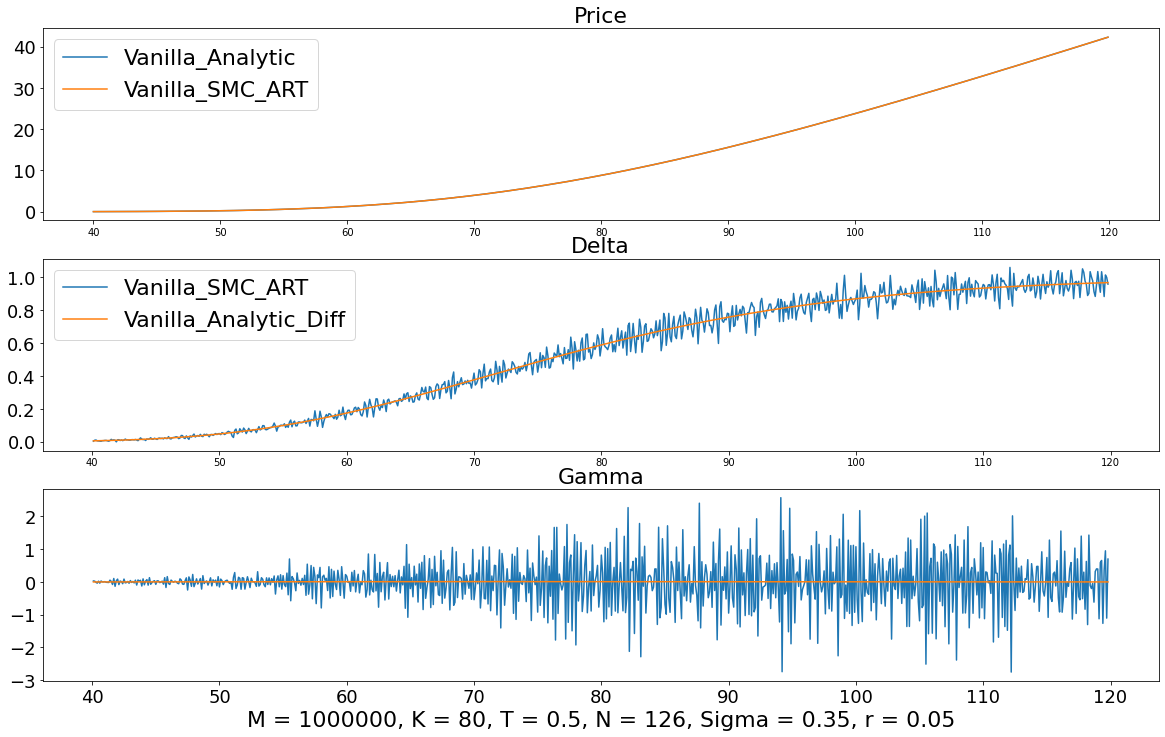

In [50]:
fig = plt.figure(figsize=(20, 12))
ax1 = fig.add_subplot(3, 1, 1)
ax1.plot(vanilla_analytic1, label="Vanilla_Analytic")
ax1.plot(smc_vanilla_art1, label="Vanilla_SMC_ART")
plt.title("Price", fontsize=22)
plt.yticks(fontsize=18)
plt.legend(fontsize=22)

ax2 = fig.add_subplot(3, 1, 2)
ax2.plot(delta(smc_vanilla_art1), label="Vanilla_SMC_ART")
ax2.plot(delta(vanilla_analytic1), label="Vanilla_Analytic_Diff")
plt.title("Delta", fontsize=22)
plt.yticks(fontsize=18)
plt.legend(fontsize=22)

ax3 = fig.add_subplot(3, 1, 3)
ax3.plot(gamma(smc_vanilla_art1))
ax3.plot(gamma(vanilla_analytic1))
plt.title("Gamma", fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("M = 1000000, K = 80, T = 0.5, N = 126, Sigma = 0.35, r = 0.05", fontsize=22)

Text(0.5, 0, 'M = 100000, K = 80, T = 0.5, N = 126, Sigma = 0.35, r = 0.05')

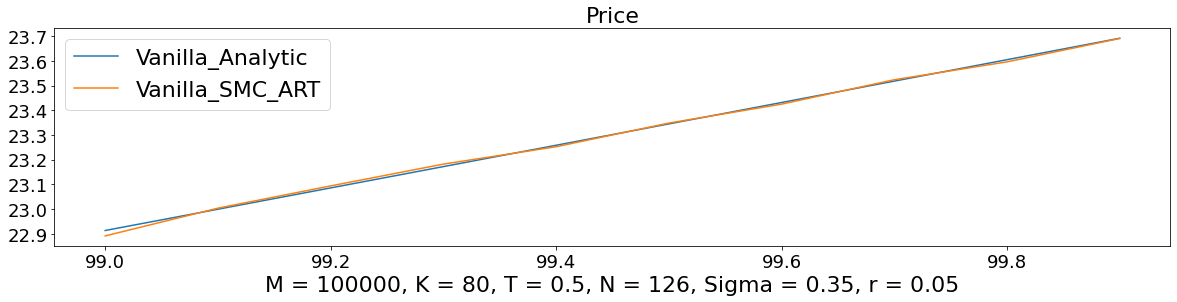

In [52]:
fig = plt.figure(figsize=(20, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(vanilla_analytic1.iloc[590:600], label="Vanilla_Analytic")
ax1.plot(smc_vanilla_art1.iloc[590:600], label="Vanilla_SMC_ART")
plt.title("Price", fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=22)
plt.xlabel("M = 100000, K = 80, T = 0.5, N = 126, Sigma = 0.35, r = 0.05", fontsize=22)

In [53]:
diff_p1 = smc_vanilla_art1 - vanilla_analytic1
print("SMC_ART Price Estimation MAX Deviation:")
print("(%f,%f)" % (diff_p1.abs().idxmax(), diff_p1.loc[diff_p1.abs().idxmax()]))

diff_d1 = delta(smc_vanilla_art1) - delta(vanilla_analytic1)
print("\nSMC_ART Delta Estimation MAX Deviation:")
print("(%f,%f)" % (diff_d1.abs().idxmax(), diff_d1.loc[diff_d1.abs().idxmax()]))
print("Correspnding locations:")
print(
    "(%f,%f)"
    % (diff_d1.abs().idxmax(), delta(vanilla_analytic1).loc[diff_d1.abs().idxmax()])
)
print(
    "(%f,%f)"
    % (diff_d1.abs().idxmax(), delta(smc_vanilla_art1).loc[diff_d1.abs().idxmax()])
)
print("Delta Vertexes:")
print(
    "(%f,%f)"
    % (
        delta(vanilla_analytic1).abs().idxmax(),
        delta(vanilla_analytic1).loc[delta(vanilla_analytic1).abs().idxmax()],
    )
)
print(
    "(%f,%f)"
    % (
        delta(smc_vanilla_art1).abs().idxmax(),
        delta(smc_vanilla_art1).loc[delta(smc_vanilla_art1).abs().idxmax()],
    )
)

diff_g1 = gamma(smc_vanilla_art1) - gamma(vanilla_analytic1)
print("\nSMC_ART Gamma Estimation MAX Deviation:")
print("(%f,%f)" % (diff_g1.abs().idxmax(), diff_g1.loc[diff_g1.abs().idxmax()]))
print("Correspnding locations:")
print(
    "(%f,%f)"
    % (diff_g1.abs().idxmax(), gamma(vanilla_analytic1).loc[diff_g1.abs().idxmax()])
)
print(
    "(%f,%f)"
    % (diff_g1.abs().idxmax(), gamma(smc_vanilla_art1).loc[diff_g1.abs().idxmax()])
)
print("Gamma Vertexes:")
print(
    "(%f,%f)"
    % (
        gamma(vanilla_analytic1).abs().idxmax(),
        gamma(vanilla_analytic1).loc[gamma(vanilla_analytic1).abs().idxmax()],
    )
)
print(
    "(%f,%f)"
    % (
        gamma(smc_vanilla_art1).abs().idxmax(),
        gamma(smc_vanilla_art1).loc[gamma(smc_vanilla_art1).abs().idxmax()],
    )
)

SMC_ART Price Estimation MAX Deviation:
(100.300000,-0.027025)

SMC_ART Delta Estimation MAX Deviation:
(100.400000,0.151681)
Correspnding locations:
(100.400000,0.873381)
(100.400000,1.025063)
Delta Vertexes:
(119.800000,0.968298)
(112.100000,1.060648)

SMC_ART Gamma Estimation MAX Deviation:
(112.200000,-2.752976)
Correspnding locations:
(112.200000,0.002024)
(112.200000,-2.750952)
Gamma Vertexes:
(71.200000,0.010982)
(112.200000,-2.750952)


## Vanilla Option - Large S Interval - 1

In [54]:
S0_vec2 = np.arange(40, 120, 1)
vanilla_analytic2 = pd.Series(
    analytic_vanilla("call", S0_vec2, 80, 0.5, 0.05, 0.35), index=S0_vec2
)
smc_vanilla_art2 = mc_vanilla("call", 1000000, 0.5, 80, 0.05, 0.35, S0_vec2, "y")

In [55]:
vanilla_analytic_delta2 = pd.Series(
    analytic_vanilla_delta("call", S0_vec2, 80, 0.5, 0.05, 0.35), index=S0_vec2
)[1:-1]
vanilla_analytic_gamma2 = pd.Series(
    analytic_vanilla_gamma("call", S0_vec2, 80, 0.5, 0.05, 0.35), index=S0_vec2
)[1:-1]

Text(0.5, 0, 'M = 1000000, K = 80, T = 0.5, N = 126, Sigma = 0.35, r = 0.05')

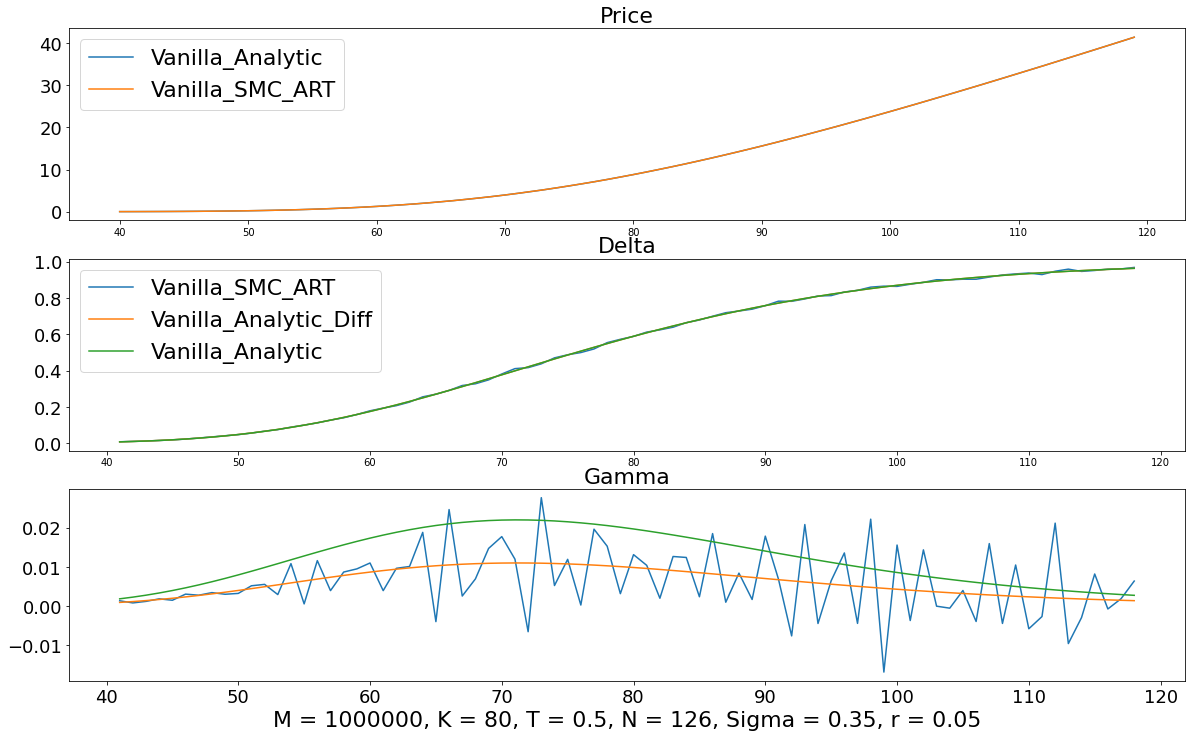

In [57]:
fig = plt.figure(figsize=(20, 12))
ax1 = fig.add_subplot(3, 1, 1)
ax1.plot(vanilla_analytic2, label="Vanilla_Analytic")
ax1.plot(smc_vanilla_art2, label="Vanilla_SMC_ART")
plt.title("Price", fontsize=22)
plt.yticks(fontsize=18)
plt.legend(fontsize=22)

ax2 = fig.add_subplot(3, 1, 2)
ax2.plot(delta(smc_vanilla_art2), label="Vanilla_SMC_ART")
ax2.plot(delta(vanilla_analytic2), label="Vanilla_Analytic_Diff")
ax2.plot(vanilla_analytic_delta2, label="Vanilla_Analytic")
plt.title("Delta", fontsize=22)
plt.yticks(fontsize=18)
plt.legend(fontsize=22)

ax3 = fig.add_subplot(3, 1, 3)
ax3.plot(gamma(smc_vanilla_art2))
ax3.plot(gamma(vanilla_analytic2))
ax3.plot(vanilla_analytic_gamma2)
plt.title("Gamma", fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("M = 1000000, K = 80, T = 0.5, N = 126, Sigma = 0.35, r = 0.05", fontsize=22)

Text(0.5, 0, 'M = 1000000, K = 80, T = 0.5, N = 126, Sigma = 0.35, r = 0.05')

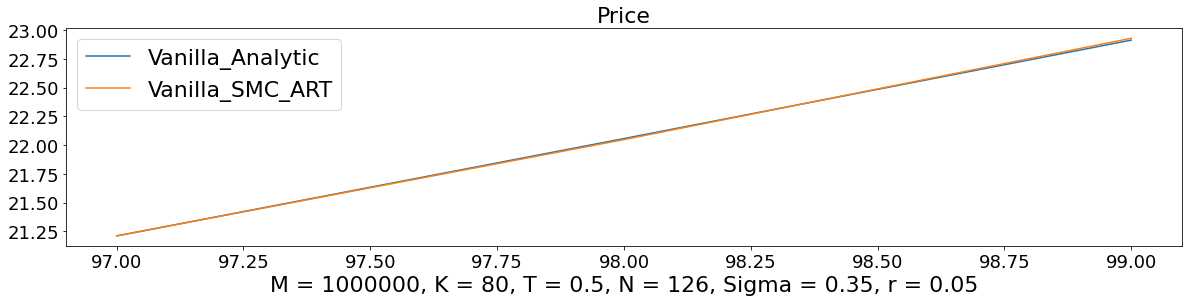

In [62]:
fig = plt.figure(figsize=(20, 4))
plt.plot(vanilla_analytic2.iloc[57:60], label="Vanilla_Analytic")
plt.plot(smc_vanilla_art2.iloc[57:60], label="Vanilla_SMC_ART")
plt.title("Price", fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=22)
plt.xlabel("M = 1000000, K = 80, T = 0.5, N = 126, Sigma = 0.35, r = 0.05", fontsize=22)

In [61]:
diff_p2 = smc_vanilla_art2 - vanilla_analytic2
print("SMC_ART Price Estimation MAX Deviation:")
print("(%f,%f)" % (diff_p2.abs().idxmax(), diff_p2.loc[diff_p2.abs().idxmax()]))

diff_d2 = delta(smc_vanilla_art2) - delta(vanilla_analytic2)
print("\nSMC_ART Delta Estimation MAX Deviation:")
print("(%f,%f)" % (diff_d2.abs().idxmax(), diff_d2.loc[diff_d2.abs().idxmax()]))
print("Correspnding locations:")
print(
    "(%f,%f)"
    % (diff_d2.abs().idxmax(), delta(vanilla_analytic2).loc[diff_d2.abs().idxmax()])
)
print(
    "(%f,%f)"
    % (diff_d2.abs().idxmax(), delta(smc_vanilla_art2).loc[diff_d2.abs().idxmax()])
)
print("Delta Vertexes:")
print(
    "(%f,%f)"
    % (
        delta(vanilla_analytic2).abs().idxmax(),
        delta(vanilla_analytic2).loc[delta(vanilla_analytic2).abs().idxmax()],
    )
)
print(
    "(%f,%f)"
    % (
        delta(smc_vanilla_art2).abs().idxmax(),
        delta(smc_vanilla_art2).loc[delta(smc_vanilla_art2).abs().idxmax()],
    )
)

diff_g2 = gamma(smc_vanilla_art2) - gamma(vanilla_analytic2)
print("\nSMC_ART Gamma Estimation MAX Deviation:")
print("(%f,%f)" % (diff_g2.abs().idxmax(), diff_g2.loc[diff_g2.abs().idxmax()]))
print("Correspnding locations:")
print(
    "(%f,%f)"
    % (diff_g2.abs().idxmax(), gamma(vanilla_analytic2).loc[diff_g2.abs().idxmax()])
)
print(
    "(%f,%f)"
    % (diff_g2.abs().idxmax(), gamma(smc_vanilla_art2).loc[diff_g2.abs().idxmax()])
)
print("Gamma Vertexes:")
print(
    "(%f,%f)"
    % (
        gamma(vanilla_analytic2).abs().idxmax(),
        gamma(vanilla_analytic2).loc[gamma(vanilla_analytic2).abs().idxmax()],
    )
)
print(
    "(%f,%f)"
    % (
        gamma(smc_vanilla_art2).abs().idxmax(),
        gamma(smc_vanilla_art2).loc[gamma(smc_vanilla_art2).abs().idxmax()],
    )
)

SMC_ART Price Estimation MAX Deviation:
(112.000000,-0.018060)

SMC_ART Delta Estimation MAX Deviation:
(71.000000,0.012137)
Correspnding locations:
(71.000000,0.398408)
(71.000000,0.410545)
Delta Vertexes:
(118.000000,0.963655)
(118.000000,0.968676)

SMC_ART Gamma Estimation MAX Deviation:
(99.000000,-0.021363)
Correspnding locations:
(99.000000,0.004516)
(99.000000,-0.016847)
Gamma Vertexes:
(71.000000,0.010979)
(73.000000,0.027631)


## Vanilla Option - Huge S Interval - 5

In [63]:
S0_vec3 = np.arange(40, 120, 5)
vanilla_analytic3 = pd.Series(
    analytic_vanilla("call", S0_vec3, 80, 0.5, 0.05, 0.35), index=S0_vec3
)
smc_vanilla_art3 = mc_vanilla("call", 1000000, 0.5, 80, 0.05, 0.35, S0_vec3, "y")

In [64]:
vanilla_analytic_delta3 = pd.Series(
    analytic_vanilla_delta("call", S0_vec3, 80, 0.5, 0.05, 0.35), index=S0_vec3
)[1:-1]
vanilla_analytic_gamma3 = pd.Series(
    analytic_vanilla_gamma("call", S0_vec3, 80, 0.5, 0.05, 0.35), index=S0_vec3
)[1:-1]

Text(0.5, 0, 'M = 1000000, K = 80, T = 0.5, N = 126, Sigma = 0.35, r = 0.05')

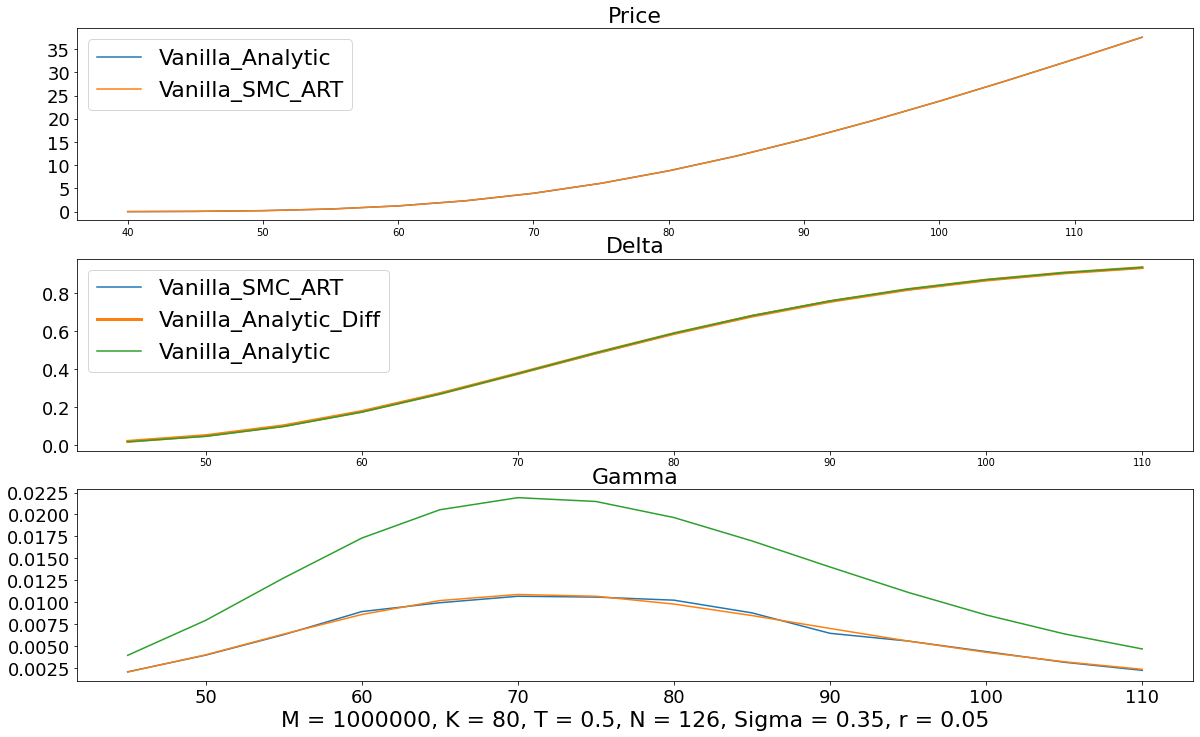

In [65]:
fig = plt.figure(figsize=(20, 12))
ax1 = fig.add_subplot(3, 1, 1)
ax1.plot(vanilla_analytic3, label="Vanilla_Analytic")
ax1.plot(smc_vanilla_art3, label="Vanilla_SMC_ART")
plt.title("Price", fontsize=22)
plt.yticks(fontsize=18)
plt.legend(fontsize=22)

ax2 = fig.add_subplot(3, 1, 2)
ax2.plot(delta(smc_vanilla_art3), label="Vanilla_SMC_ART")
ax2.plot(delta(vanilla_analytic3), label="Vanilla_Analytic_Diff", linewidth=3)
ax2.plot(vanilla_analytic_delta3, label="Vanilla_Analytic")
plt.title("Delta", fontsize=22)
plt.yticks(fontsize=18)
plt.legend(fontsize=22)

ax3 = fig.add_subplot(3, 1, 3)
ax3.plot(gamma(smc_vanilla_art3))
ax3.plot(gamma(vanilla_analytic3))
ax3.plot(vanilla_analytic_gamma3)
plt.title("Gamma", fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("M = 1000000, K = 80, T = 0.5, N = 126, Sigma = 0.35, r = 0.05", fontsize=22)

Text(0.5, 0, 'M = 1000000, K = 80, T = 0.5, N = 126, Sigma = 0.35, r = 0.05')

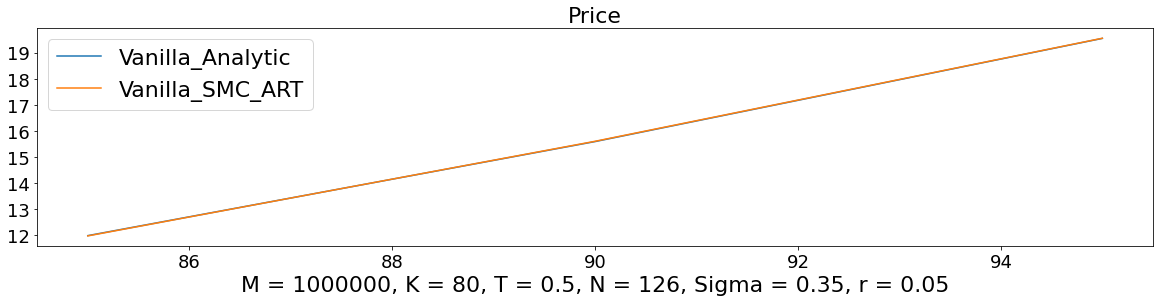

In [70]:
fig = plt.figure(figsize=(20, 4))
plt.plot(vanilla_analytic3.iloc[9:12], label="Vanilla_Analytic")
plt.plot(smc_vanilla_art3.iloc[9:12], label="Vanilla_SMC_ART")
plt.title("Price", fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=22)
plt.xlabel("M = 1000000, K = 80, T = 0.5, N = 126, Sigma = 0.35, r = 0.05", fontsize=22)

In [73]:
diff_p3 = smc_vanilla_art3 - vanilla_analytic3
print("SMC_ART Price Estimation MAX Deviation:")
print("(%f,%f)" % (diff_p3.abs().idxmax(), diff_p3.loc[diff_p3.abs().idxmax()]))

diff_d3 = delta(smc_vanilla_art3) - delta(vanilla_analytic3)
print("\nSMC_ART Delta Estimation MAX Deviation:")
print("(%f,%f)" % (diff_d3.abs().idxmax(), diff_d3.loc[diff_d3.abs().idxmax()]))
print("Correspnding locations:")
print(
    "(%f,%f)"
    % (diff_d3.abs().idxmax(), delta(vanilla_analytic3).loc[diff_d3.abs().idxmax()])
)
print(
    "(%f,%f)"
    % (diff_d3.abs().idxmax(), delta(smc_vanilla_art3).loc[diff_d3.abs().idxmax()])
)
print("Delta Vertexes:")
print(
    "(%f,%f)"
    % (
        delta(vanilla_analytic3).abs().idxmax(),
        delta(vanilla_analytic3).loc[delta(vanilla_analytic3).abs().idxmax()],
    )
)
print(
    "(%f,%f)"
    % (
        delta(smc_vanilla_art3).abs().idxmax(),
        delta(smc_vanilla_art3).loc[delta(smc_vanilla_art3).abs().idxmax()],
    )
)

dev_delta3 = vanilla_analytic_delta3[1:-1] - delta(vanilla_analytic3)
print("\nVanilla_Analytic Delta Estimation MAX Deviation:")
print(
    "(%f,%f)" % (dev_delta3.abs().idxmax(), dev_delta3.loc[dev_delta3.abs().idxmax()])
)

diff_g3 = gamma(smc_vanilla_art3) - gamma(vanilla_analytic3)
print("\nSMC_ART Gamma Estimation MAX Deviation:")
print("(%f,%f)" % (diff_g3.abs().idxmax(), diff_g3.loc[diff_g3.abs().idxmax()]))
print("Correspnding locations:")
print(
    "(%f,%f)"
    % (diff_g3.abs().idxmax(), gamma(vanilla_analytic3).loc[diff_g3.abs().idxmax()])
)
print(
    "(%f,%f)"
    % (diff_g3.abs().idxmax(), gamma(smc_vanilla_art3).loc[diff_g3.abs().idxmax()])
)
print("Gamma Vertexes:")
print(
    "(%f,%f)"
    % (
        gamma(vanilla_analytic3).abs().idxmax(),
        gamma(vanilla_analytic3).loc[gamma(vanilla_analytic3).abs().idxmax()],
    )
)
print(
    "(%f,%f)"
    % (
        gamma(smc_vanilla_art3).abs().idxmax(),
        gamma(smc_vanilla_art3).loc[gamma(smc_vanilla_art3).abs().idxmax()],
    )
)

dev_gamma3 = vanilla_analytic_gamma3[1:-1] - gamma(vanilla_analytic3)
print("\nVanilla_Analytic Gamma Estimation MAX Deviation:")
print(
    "(%f,%f)" % (dev_gamma3.abs().idxmax(), dev_gamma3.loc[dev_gamma3.abs().idxmax()])
)

SMC_ART Price Estimation MAX Deviation:
(80.000000,-0.018356)

SMC_ART Delta Estimation MAX Deviation:
(85.000000,0.002965)
Correspnding locations:
(85.000000,0.678329)
(85.000000,0.681294)
Delta Vertexes:
(110.000000,0.933409)
(110.000000,0.932059)

Vanilla_Analytic Delta Estimation MAX Deviation:
(55.000000,-0.004021)

SMC_ART Gamma Estimation MAX Deviation:
(90.000000,-0.000554)
Correspnding locations:
(90.000000,0.007010)
(90.000000,0.006456)
Gamma Vertexes:
(70.000000,0.010881)
(70.000000,0.010679)

Vanilla_Analytic Gamma Estimation MAX Deviation:
(70.000000,0.011034)


## Vanilla Option - Huge S Interval - 10

In [74]:
S0_vec4 = np.arange(40, 120, 10)
vanilla_analytic4 = pd.Series(
    analytic_vanilla("call", S0_vec4, 80, 0.5, 0.05, 0.35), index=S0_vec4
)
smc_vanilla_art4 = mc_vanilla("call", 1000000, 0.5, 80, 0.05, 0.35, S0_vec4, "y")

In [75]:
vanilla_analytic_delta4 = pd.Series(
    analytic_vanilla_delta("call", S0_vec4, 80, 0.5, 0.05, 0.35), index=S0_vec4
)[1:-1]
vanilla_analytic_gamma4 = pd.Series(
    analytic_vanilla_gamma("call", S0_vec4, 80, 0.5, 0.05, 0.35), index=S0_vec4
)[1:-1]

Text(0.5, 0, 'M = 1000000, K = 80, T = 0.5, N = 126, Sigma = 0.35, r = 0.05')

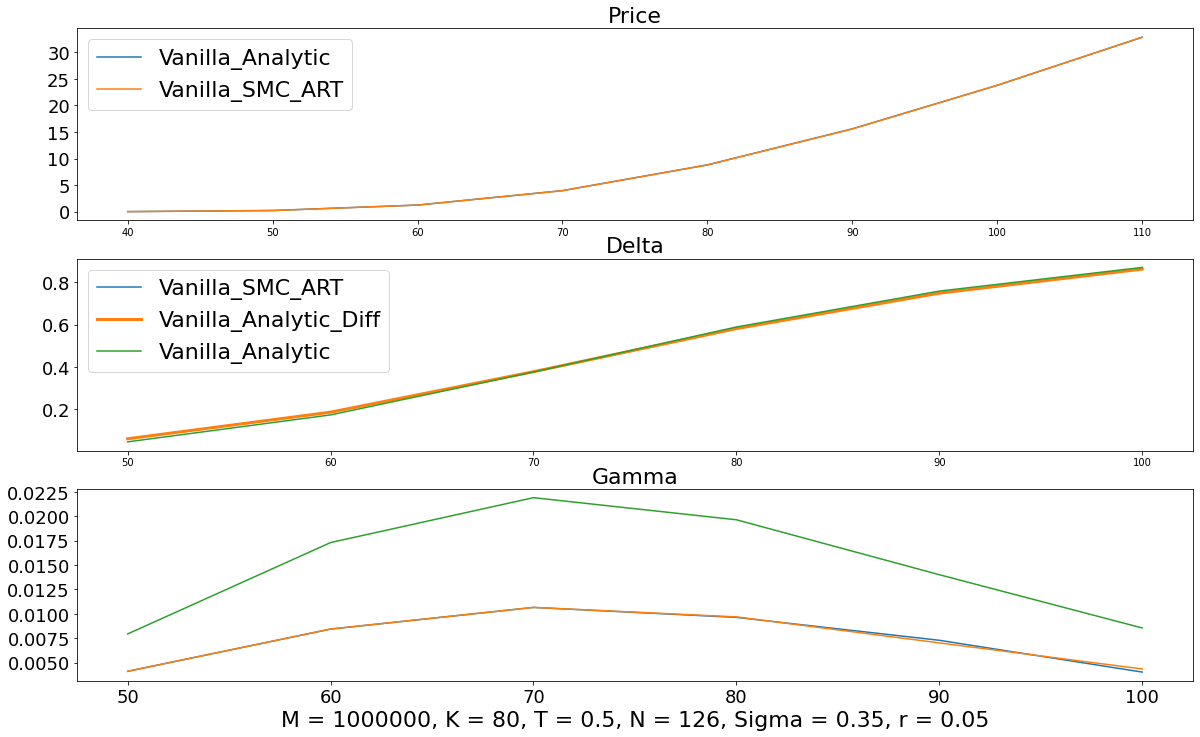

In [76]:
fig = plt.figure(figsize=(20, 12))
ax1 = fig.add_subplot(3, 1, 1)
ax1.plot(vanilla_analytic4, label="Vanilla_Analytic")
ax1.plot(smc_vanilla_art4, label="Vanilla_SMC_ART")
plt.title("Price", fontsize=22)
plt.yticks(fontsize=18)
plt.legend(fontsize=22)

ax2 = fig.add_subplot(3, 1, 2)
ax2.plot(delta(smc_vanilla_art4), label="Vanilla_SMC_ART")
ax2.plot(delta(vanilla_analytic4), label="Vanilla_Analytic_Diff", linewidth=3)
ax2.plot(vanilla_analytic_delta4, label="Vanilla_Analytic")
plt.title("Delta", fontsize=22)
plt.yticks(fontsize=18)
plt.legend(fontsize=22)

ax3 = fig.add_subplot(3, 1, 3)
ax3.plot(gamma(smc_vanilla_art4))
ax3.plot(gamma(vanilla_analytic4))
ax3.plot(vanilla_analytic_gamma4)
plt.title("Gamma", fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("M = 1000000, K = 80, T = 0.5, N = 126, Sigma = 0.35, r = 0.05", fontsize=22)

Text(0.5, 0, 'M = 1000000, K = 80, T = 0.5, N = 126, Sigma = 0.35, r = 0.05')

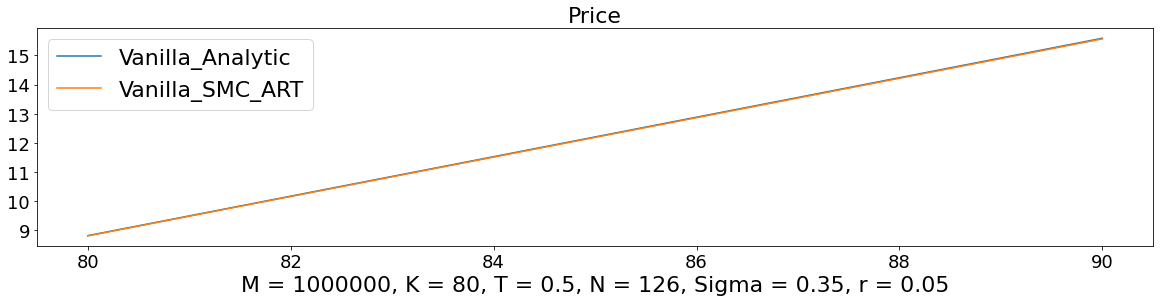

In [77]:
fig = plt.figure(figsize=(20, 4))
plt.plot(vanilla_analytic4.iloc[4:6], label="Vanilla_Analytic")
plt.plot(smc_vanilla_art4.iloc[4:6], label="Vanilla_SMC_ART")
plt.title("Price", fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=22)
plt.xlabel("M = 1000000, K = 80, T = 0.5, N = 126, Sigma = 0.35, r = 0.05", fontsize=22)

In [78]:
diff_p4 = smc_vanilla_art4 - vanilla_analytic4
print("SMC_ART Price Estimation MAX Deviation:")
print("(%f,%f)" % (diff_p4.abs().idxmax(), diff_p4.loc[diff_p4.abs().idxmax()]))

diff_d4 = delta(smc_vanilla_art4) - delta(vanilla_analytic4)
print("\nSMC_ART Delta Estimation MAX Deviation:")
print("(%f,%f)" % (diff_d4.abs().idxmax(), diff_d4.loc[diff_d4.abs().idxmax()]))
print("Correspnding locations:")
print(
    "(%f,%f)"
    % (diff_d4.abs().idxmax(), delta(vanilla_analytic4).loc[diff_d4.abs().idxmax()])
)
print(
    "(%f,%f)"
    % (diff_d4.abs().idxmax(), delta(smc_vanilla_art4).loc[diff_d4.abs().idxmax()])
)
print("Delta Vertexes:")
print(
    "(%f,%f)"
    % (
        delta(vanilla_analytic4).abs().idxmax(),
        delta(vanilla_analytic4).loc[delta(vanilla_analytic4).abs().idxmax()],
    )
)
print(
    "(%f,%f)"
    % (
        delta(smc_vanilla_art4).abs().idxmax(),
        delta(smc_vanilla_art4).loc[delta(smc_vanilla_art4).abs().idxmax()],
    )
)

dev_delta4 = vanilla_analytic_delta4[1:-1] - delta(vanilla_analytic4)
print("\nVanilla_Analytic Delta Estimation MAX Deviation:")
print(
    "(%f,%f)" % (dev_delta4.abs().idxmax(), dev_delta4.loc[dev_delta4.abs().idxmax()])
)

diff_g4 = gamma(smc_vanilla_art4) - gamma(vanilla_analytic4)
print("\nSMC_ART Gamma Estimation MAX Deviation:")
print("(%f,%f)" % (diff_g4.abs().idxmax(), diff_g4.loc[diff_g4.abs().idxmax()]))
print("Correspnding locations:")
print(
    "(%f,%f)"
    % (diff_g4.abs().idxmax(), gamma(vanilla_analytic4).loc[diff_g4.abs().idxmax()])
)
print(
    "(%f,%f)"
    % (diff_g4.abs().idxmax(), gamma(smc_vanilla_art4).loc[diff_g4.abs().idxmax()])
)
print("Gamma Vertexes:")
print(
    "(%f,%f)"
    % (
        gamma(vanilla_analytic4).abs().idxmax(),
        gamma(vanilla_analytic4).loc[gamma(vanilla_analytic4).abs().idxmax()],
    )
)
print(
    "(%f,%f)"
    % (
        gamma(smc_vanilla_art4).abs().idxmax(),
        gamma(smc_vanilla_art4).loc[gamma(smc_vanilla_art4).abs().idxmax()],
    )
)

dev_gamma4 = vanilla_analytic_gamma4[1:-1] - gamma(vanilla_analytic4)
print("\nVanilla_Analytic Gamma Estimation MAX Deviation:")
print(
    "(%f,%f)" % (dev_gamma4.abs().idxmax(), dev_gamma4.loc[dev_gamma4.abs().idxmax()])
)

SMC_ART Price Estimation MAX Deviation:
(90.000000,-0.022772)

SMC_ART Delta Estimation MAX Deviation:
(90.000000,0.001317)
Correspnding locations:
(90.000000,0.748512)
(90.000000,0.749830)
Delta Vertexes:
(100.000000,0.862128)
(100.000000,0.862905)

Vanilla_Analytic Delta Estimation MAX Deviation:
(60.000000,-0.012865)

SMC_ART Gamma Estimation MAX Deviation:
(100.000000,-0.000320)
Correspnding locations:
(100.000000,0.004343)
(100.000000,0.004023)
Gamma Vertexes:
(70.000000,0.010658)
(70.000000,0.010656)

Vanilla_Analytic Gamma Estimation MAX Deviation:
(70.000000,0.011257)


## Vanilla Option - Variance Reduction Analysis

### Convergency Analysis

In [81]:
%%time
M_vec = np.arange(50000, 100000, 100)
smc_vanilla_vec = np.zeros(M_vec.shape)
qmc_vanilla_vec = np.zeros(M_vec.shape)
smc_vanilla_art_vec = np.zeros(M_vec.shape)
qmc_vanilla_art_vec = np.zeros(M_vec.shape)
qmc_vanilla_art_randomize_vec = np.zeros(M_vec.shape)

analytic_vanilla_vec = analytic_vanilla("call", 83, 80, 0.5, 0.05, 0.35) * np.ones(
    M_vec.shape
)

for x in range(len(M_vec)):
    smc_vanilla_vec[x] = mc_vanilla(
        "call", M_vec[x], 0.5, 80, 0.05, 0.35, np.array([83])
    )
    qmc_vanilla_vec[x] = mc_vanilla(
        "call", M_vec[x], 0.5, 80, 0.05, 0.35, np.array([83]), "n", "y", 2000
    )
    smc_vanilla_art_vec[x] = mc_vanilla(
        "call", M_vec[x], 0.5, 80, 0.05, 0.35, np.array([83]), "y"
    )
    qmc_vanilla_art_vec[x] = mc_vanilla(
        "call", M_vec[x], 0.5, 80, 0.05, 0.35, np.array([83]), "y", "y", 2000
    )
    qmc_vanilla_art_randomize_vec[x] = mc_vanilla(
        "call", M_vec[x], 0.5, 80, 0.05, 0.35, np.array([83]), "y", "y", 2000, "y"
    )

smc_vanilla_vec = pd.DataFrame(smc_vanilla_vec, index=M_vec)
qmc_vanilla_vec = pd.DataFrame(qmc_vanilla_vec, index=M_vec)
smc_vanilla_art_vec = pd.DataFrame(smc_vanilla_art_vec, index=M_vec)
qmc_vanilla_art_vec = pd.DataFrame(qmc_vanilla_art_vec, index=M_vec)
qmc_vanilla_art_randomize_vec = pd.DataFrame(qmc_vanilla_art_randomize_vec, index=M_vec)

CPU times: user 25min 46s, sys: 25.1 s, total: 26min 11s
Wall time: 25min 39s


(array([10.45, 10.5 , 10.55, 10.6 , 10.65, 10.7 , 10.75, 10.8 , 10.85,
        10.9 ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

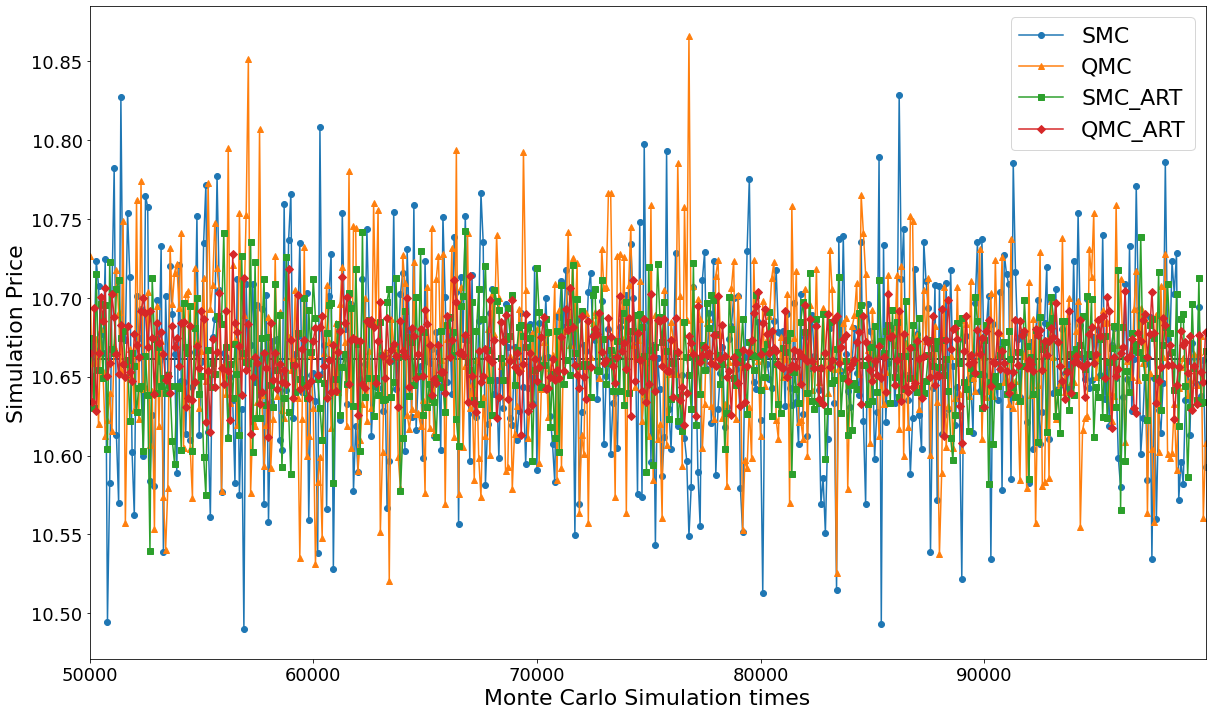

In [82]:
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(1, 1, 1)

ax.plot(M_vec, analytic_vanilla_vec, color="k")
plt.plot(M_vec, smc_vanilla_vec, marker="o", label="SMC")
plt.plot(M_vec, qmc_vanilla_vec, marker="^", label="QMC")
plt.plot(M_vec, smc_vanilla_art_vec, marker="s", label="SMC_ART")
plt.plot(M_vec, qmc_vanilla_art_vec, marker="D", label="QMC_ART")
plt.xlim(M_vec[0], M_vec[-1])
plt.xlabel("Monte Carlo Simulation times", fontsize=22)
plt.ylabel("Simulation Price", fontsize=22)
plt.legend(fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

(array([10.5 , 10.55, 10.6 , 10.65, 10.7 , 10.75, 10.8 , 10.85, 10.9 ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

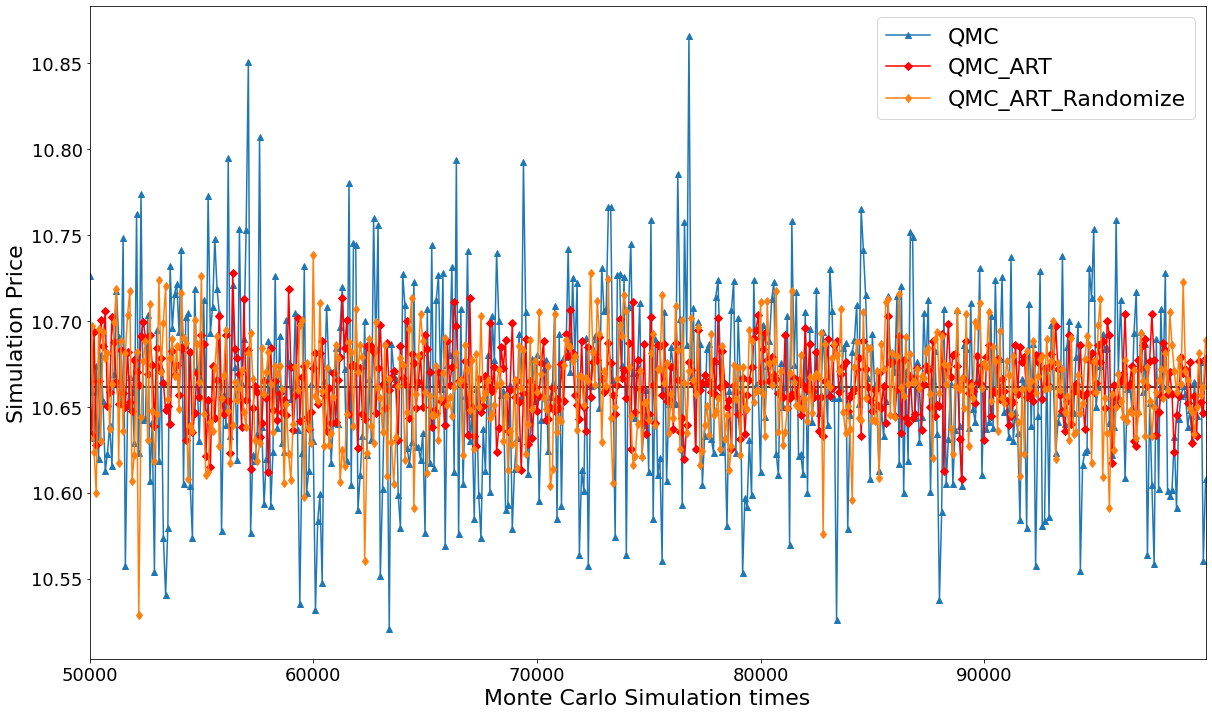

In [83]:
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(1, 1, 1)

ax.plot(M_vec, analytic_vanilla_vec, color="k")
plt.plot(M_vec, qmc_vanilla_vec, marker="^", label="QMC")
plt.plot(M_vec, qmc_vanilla_art_vec, marker="D", color="r", label="QMC_ART")
plt.plot(M_vec, qmc_vanilla_art_randomize_vec, marker="d", label="QMC_ART_Randomize")
plt.xlim(M_vec[0], M_vec[-1])
plt.xlabel("Monte Carlo Simulation times", fontsize=22)
plt.ylabel("Simulation Price", fontsize=22)
plt.legend(fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

### Deviation Analysis

In [97]:
%%time
S0_vec6 = np.arange(60, 120, 0.1)
smc_vanilla6 = mc_vanilla("call", 1000000, 0.5, 80, 0.05, 0.35, S0_vec6)
smc_vanilla_art6 = mc_vanilla("call", 1000000, 0.5, 80, 0.05, 0.35, S0_vec6, "y")
qmc_vanilla6 = mc_vanilla("call", 1000000, 0.5, 80, 0.05, 0.35, S0_vec6, "y", "y", 2000)
qmc_vanilla_art6 = mc_vanilla(
    "call", 1000000, 0.5, 80, 0.05, 0.35, S0_vec6, "y", "y", 2000
)
qmc_vanilla_art_randomize6 = mc_vanilla(
    "call", 1000000, 0.5, 80, 0.05, 0.35, S0_vec6, "y", "y", 2000, "y"
)

CPU times: user 17min 46s, sys: 9min, total: 26min 46s
Wall time: 18min 19s


In [98]:
vanilla_analytic6 = pd.Series(
    analytic_vanilla("call", S0_vec6, 80, 0.5, 0.05, 0.35), index=S0_vec6
)
vanilla_analytic_delta6 = pd.Series(
    analytic_vanilla_delta("call", S0_vec6, 80, 0.5, 0.05, 0.35), index=S0_vec6
).iloc[1:-1]
vanilla_analytic_gamma6 = pd.Series(
    analytic_vanilla_gamma("call", S0_vec6, 80, 0.5, 0.05, 0.35), index=S0_vec6
).iloc[1:-1]

(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

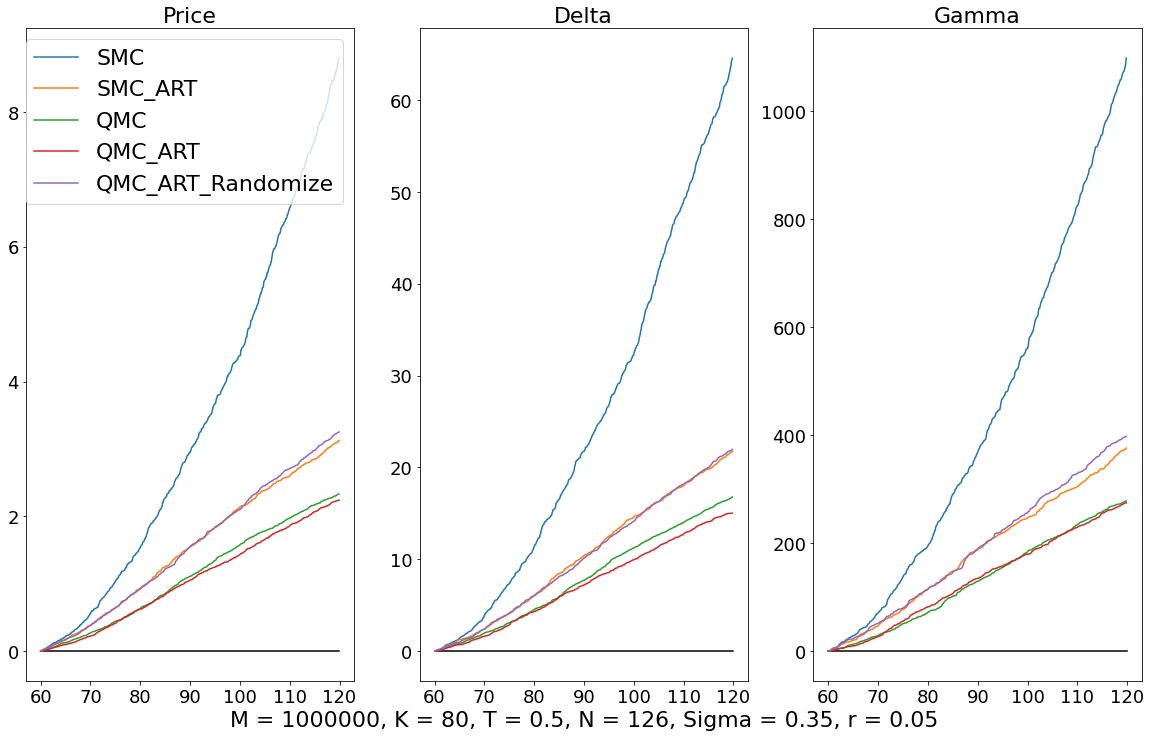

In [100]:
fig = plt.figure(figsize=(20, 12))
ax1 = fig.add_subplot(1, 3, 1)
ax1.plot(S0_vec6, np.zeros(S0_vec6.shape), color="k")
ax1.plot(
    (smc_vanilla6 - vanilla_analytic6).abs().cumsum(), label="SMC",
)
ax1.plot(
    (smc_vanilla_art6 - vanilla_analytic6).abs().cumsum(), label="SMC_ART",
)
ax1.plot((qmc_vanilla6 - vanilla_analytic6).abs().cumsum(), label="QMC")
ax1.plot(
    (qmc_vanilla_art6 - vanilla_analytic6).abs().cumsum(), label="QMC_ART",
)
ax1.plot(
    (qmc_vanilla_art_randomize6 - vanilla_analytic6).abs().cumsum(),
    label="QMC_ART_Randomize",
)
plt.title("Price", fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=22)

ax2 = fig.add_subplot(1, 3, 2)
ax2.plot(S0_vec6, np.zeros(S0_vec6.shape), color="k")
ax2.plot((delta(smc_vanilla6) - vanilla_analytic_delta6).abs().cumsum(),)
ax2.plot((delta(smc_vanilla_art6) - vanilla_analytic_delta6).abs().cumsum(),)
ax2.plot((delta(qmc_vanilla6) - vanilla_analytic_delta6).abs().cumsum(),)
ax2.plot((delta(qmc_vanilla_art6) - vanilla_analytic_delta6).abs().cumsum(),)
ax2.plot((delta(qmc_vanilla_art_randomize6) - vanilla_analytic_delta6).abs().cumsum(),)
plt.title("Delta", fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("M = 1000000, K = 80, T = 0.5, N = 126, Sigma = 0.35, r = 0.05", fontsize=22)

ax3 = fig.add_subplot(1, 3, 3)
ax3.plot(S0_vec6, np.zeros(S0_vec6.shape), color="k")
ax3.plot((gamma(smc_vanilla6) - vanilla_analytic_gamma6).abs().cumsum(),)
ax3.plot((gamma(smc_vanilla_art6) - vanilla_analytic_gamma6).abs().cumsum(),)
ax3.plot((gamma(qmc_vanilla6) - vanilla_analytic_gamma6).abs().cumsum(),)
ax3.plot((gamma(qmc_vanilla_art6) - vanilla_analytic_gamma6).abs().cumsum(),)
ax3.plot((gamma(qmc_vanilla_art_randomize6) - vanilla_analytic_gamma6).abs().cumsum(),)
plt.title("Gamma", fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

(array([-3., -2., -1.,  0.,  1.,  2.,  3.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

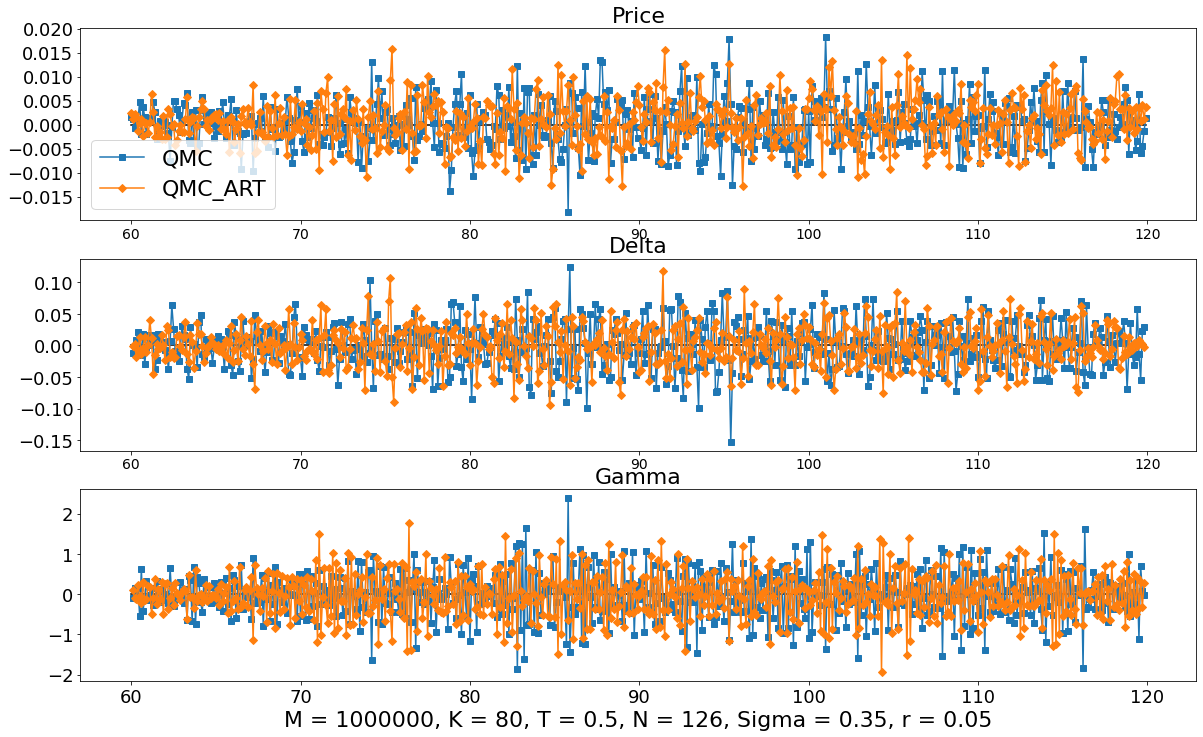

In [101]:
fig = plt.figure(figsize=(20, 12))
ax1 = fig.add_subplot(3, 1, 1)
ax1.plot(S0_vec6, np.zeros(S0_vec6.shape), color="k")
ax1.plot((qmc_vanilla6 - vanilla_analytic6), marker="s", label="QMC")
ax1.plot(
    (qmc_vanilla_art6 - vanilla_analytic6), marker="D", label="QMC_ART",
)
plt.title("Price", fontsize=22)
plt.xticks(fontsize=14)
plt.yticks(fontsize=18)
plt.legend(fontsize=22)

ax2 = fig.add_subplot(3, 1, 2)
ax2.plot(S0_vec6, np.zeros(S0_vec6.shape), color="k")
ax2.plot(
    (delta(qmc_vanilla6) - vanilla_analytic_delta6), marker="s",
)
ax2.plot(
    (delta(qmc_vanilla_art6) - vanilla_analytic_delta6), marker="D",
)
plt.title("Delta", fontsize=22)
plt.xticks(fontsize=14)
plt.yticks(fontsize=18)


ax3 = fig.add_subplot(3, 1, 3)
ax3.plot(S0_vec6, np.zeros(S0_vec6.shape), color="k")
ax3.plot(
    (gamma(qmc_vanilla6) - vanilla_analytic_gamma6), marker="s",
)
ax3.plot(
    (gamma(qmc_vanilla_art6) - vanilla_analytic_gamma6), marker="D",
)
plt.title("Gamma", fontsize=22)
plt.xlabel("M = 1000000, K = 80, T = 0.5, N = 126, Sigma = 0.35, r = 0.05", fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

### ART Effeciency Analysis

In [90]:
def mc_vanilla_analyze(
    cp_flag,
    M,
    T,
    K,
    mu,
    sigma,
    S0_vec,
    art="n",
    quasi="n",
    skip=0,
    randomize="n",
    sampling_method="direct",
):

    if sampling_method == "direct":
        pass
    else:
        raise ValueError(
            "Input Error: Incorrect passed parameter sampling_method! "
            + "Sampling_method of fuction mc_vanilla can only be direct"
        )

    if quasi == "y":
        quasi_epsilon_vec = sobol_seq.i4_sobol_generate(1, M, skip)
    elif quasi == "n":
        pass
    else:
        raise ValueError("Input Error: Incorrect passed parameter quasi!")

    if art == "y":
        stock_price_paths_vec_art = {}
    elif art == "n":
        pass
    else:
        raise ValueError("Input Error: Incorrect passed parameter art!")

    result_vec = []
    stock_price_paths_vec = {}
    if art == "y":
        stock_price_paths_vec_art = {}

    for S0 in S0_vec:
        if quasi == "y":
            if randomize == "y":
                epsilon_vec = quasi_seq_uniform_to_randomized_std_normal(
                    quasi_epsilon_vec
                )
            elif randomize == "n":
                epsilon_vec = Box_Muller(quasi_epsilon_vec)
            else:
                raise ValueError("Input Error: Incorrect passed parameter randomize!")
        else:
            epsilon_vec = np.random.normal(0, 1, (M, 1))
        if art == "y":
            stock_price_paths_vec_art[S0] = S0 * np.exp(
                (mu - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * (-epsilon_vec)
            )
        stock_price_paths_vec[S0] = S0 * np.exp(
            (mu - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * epsilon_vec
        )

    stock_price_paths_vec = [stock_price_paths_vec]
    if art == "y":
        stock_price_paths_vec.append(stock_price_paths_vec_art)

    for i in range(len(stock_price_paths_vec)):
        end_price = pd.DataFrame(np.zeros((M, S0_vec.shape[0])), columns=S0_vec)
        for j in range(S0_vec.shape[0]):
            end_price.iloc[:, j] = stock_price_paths_vec[i][S0_vec[j]]

        discount = np.exp(
            -mu * pd.DataFrame(np.ones((M, S0_vec.shape[0])), columns=S0_vec) * T
        )
        if cp_flag == "call":
            end_value = (
                pd.DataFrame(np.where(end_price > K, end_price - K, 0), columns=S0_vec)
                * discount
            )
        elif cp_flag == "put":
            end_value = (
                pd.DataFrame(np.where(K > end_price, K - end_price, 0), columns=S0_vec)
                * discount
            )
        result_vec.append(end_value)

    return result_vec

In [93]:
S0_vec5 = np.arange(40, 120)
analytic_vanilla_vec = pd.DataFrame(
    analytic_vanilla("call", S0_vec5, 80, 0.5, 0.05, 0.35), index=S0_vec5
)
f1, f2 = mc_vanilla_analyze("call", 1000000, 0.5, 80, 0.05, 0.35, S0_vec5, "y")
f3, f4 = mc_vanilla_analyze(
    "call", 1000000, 0.5, 80, 0.05, 0.35, S0_vec5, "y", "y", 2000
)
f5, f6 = mc_vanilla_analyze(
    "call", 1000000, 0.5, 80, 0.05, 0.35, S0_vec5, "y", "y", 2000, "y"
)

In [94]:
%%time
A = art_effeciency_analysis(f1, f2, S0_vec5)

CPU times: user 36min 2s, sys: 40 s, total: 36min 42s
Wall time: 36min 46s


In [95]:
%%time
B = art_effeciency_analysis(f3, f4, S0_vec5)

CPU times: user 36min 15s, sys: 35.1 s, total: 36min 50s
Wall time: 36min 54s


In [96]:
%%time
C = art_effeciency_analysis(f5, f6, S0_vec5)

CPU times: user 36min 22s, sys: 36.1 s, total: 36min 58s
Wall time: 37min 2s


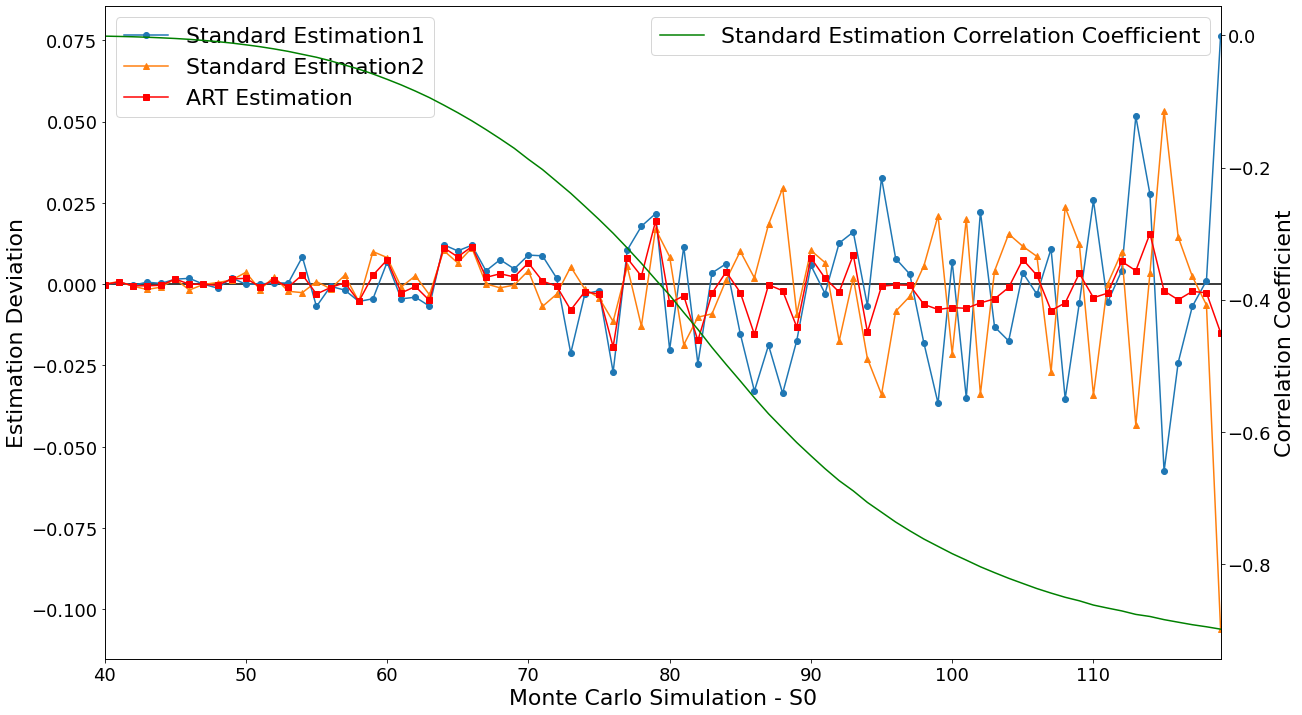

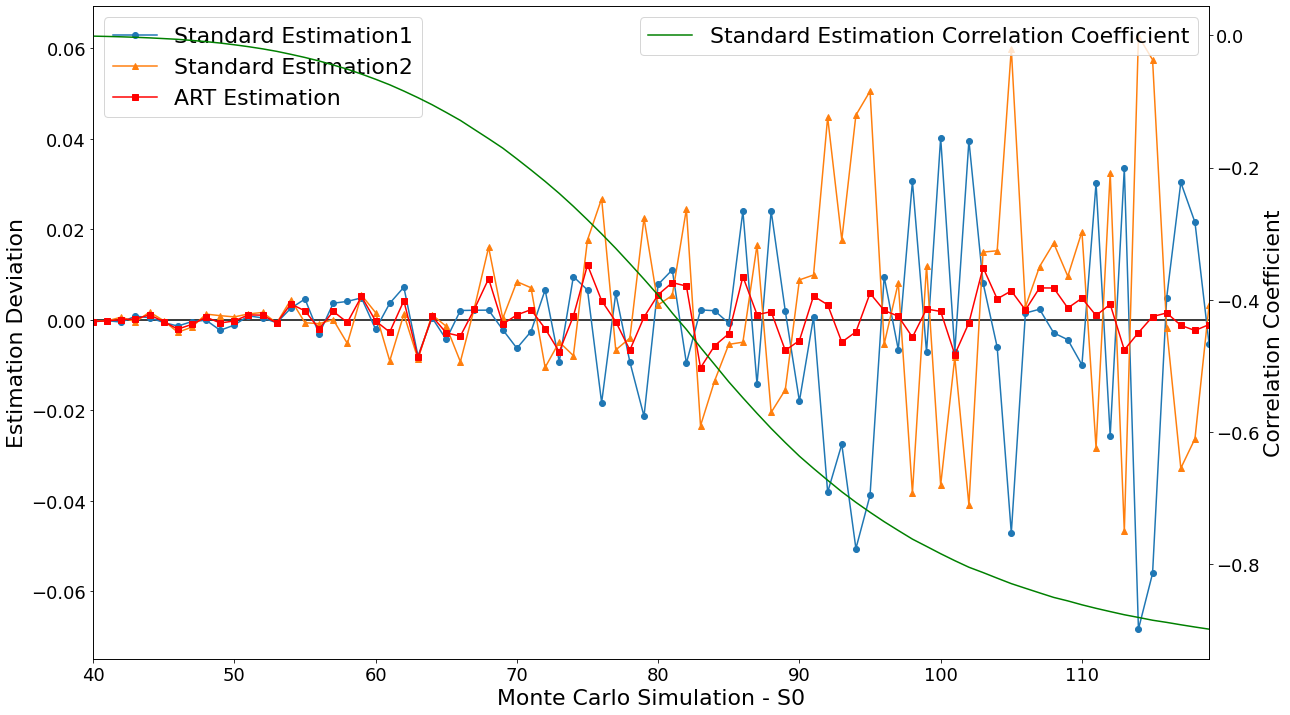

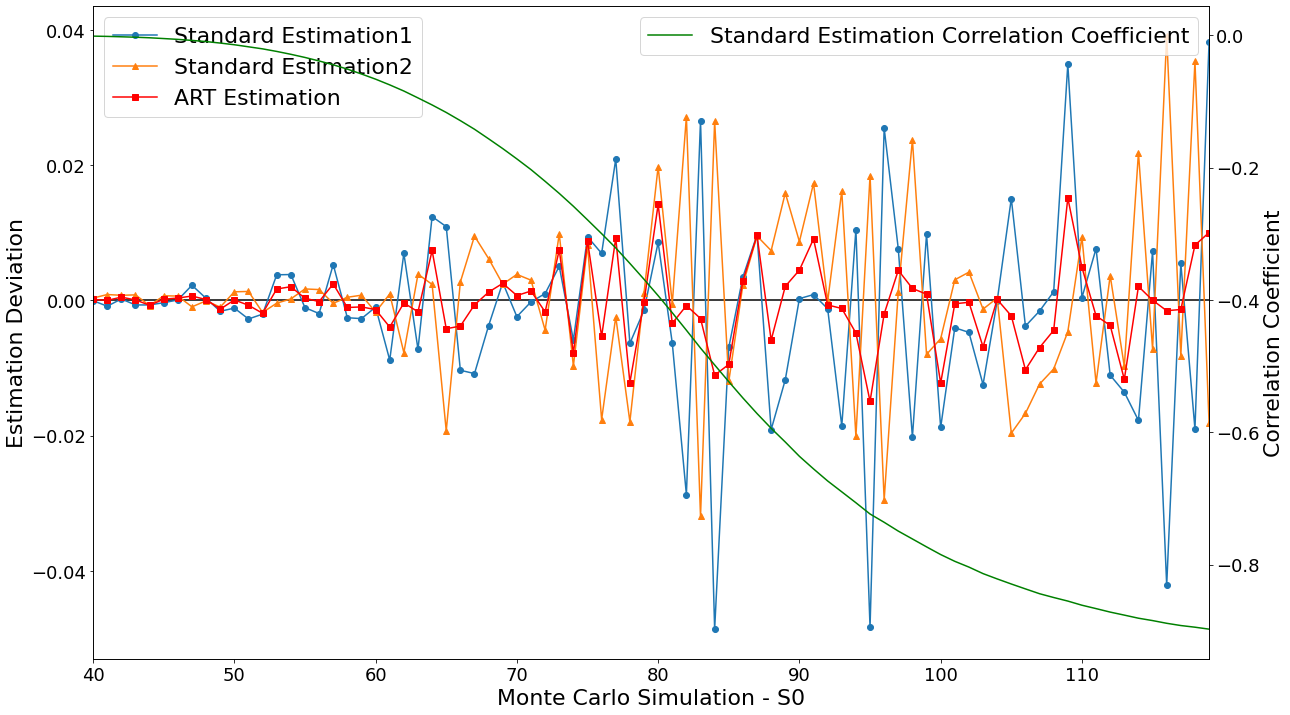

In [102]:
art_effeciency_analysis_show(A, analytic_vanilla_vec, S0_vec5)
art_effeciency_analysis_show(B, analytic_vanilla_vec, S0_vec5)
art_effeciency_analysis_show(C, analytic_vanilla_vec, S0_vec5)

## Vanilla Opiton - Monte Carlo Fitting - Small S Interval - 0.1

In [14]:
S0_vec7 = np.arange(40, 120, 0.1)
vanilla_analytic7 = pd.Series(
    analytic_vanilla("call", S0_vec7, 80, 0.5, 0.05, 0.35), index=S0_vec7
)
qmc_vanilla_art_randomize7 = mc_vanilla(
    "call", 1000000, 0.5, 80, 0.05, 0.35, S0_vec7, "y", "y", 2000, "y"
)

Text(0.5, 0, 'M = 1000000, K = 80, T = 0.5, N = 126, Sigma = 0.35, r = 0.05')

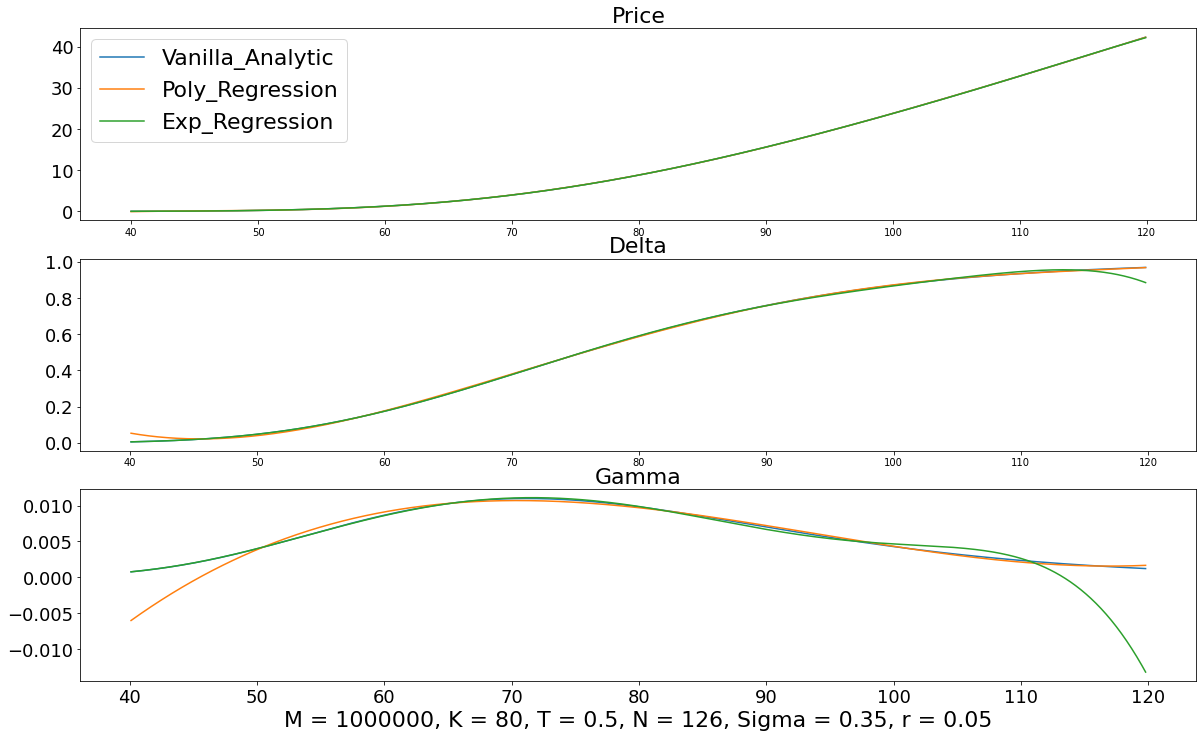

In [71]:
fig = plt.figure(figsize=(20, 12))
ax1 = fig.add_subplot(3, 1, 1)
ax1.plot(vanilla_analytic7, label="Vanilla_Analytic")

ax1.plot(
    polyfit(qmc_vanilla_art_randomize7, 5), label="Poly_Regression",
)
ax1.plot(
    expfit(qmc_vanilla_art_randomize7, 6), label="Exp_Regression",
)
plt.title("Price", fontsize=22)
plt.yticks(fontsize=18)
plt.legend(fontsize=22)

ax2 = fig.add_subplot(3, 1, 2)
ax2.plot(delta(vanilla_analytic7))
ax2.plot(delta(polyfit(qmc_vanilla_art_randomize7, 5)))
ax2.plot(delta(expfit(qmc_vanilla_art_randomize7, 6)))
plt.title("Delta", fontsize=22)
plt.yticks(fontsize=18)

ax3 = fig.add_subplot(3, 1, 3)
ax3.plot(gamma(vanilla_analytic7))
ax3.plot(gamma(polyfit(qmc_vanilla_art_randomize7, 5)))
ax3.plot(gamma(expfit(qmc_vanilla_art_randomize7, 6)))
plt.title("Gamma", fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("M = 1000000, K = 80, T = 0.5, N = 126, Sigma = 0.35, r = 0.05", fontsize=22)

In [21]:
a1 = delta(qmc_vanilla_art_randomize7)
delta_smooth = (a1.shift(-1) + a1.shift(1) + a1.shift(-2) + a1.shift(2) + a1) / 5
b1 = gamma(qmc_vanilla_art_randomize7)
gamma_smooth = (
    b1.shift(-1)
    + b1.shift(-2)
    + b1.shift(-3)
    + b1.shift(-4)
    + b1.shift(-5)
    + b1.shift(1)
    + b1.shift(2)
    + b1.shift(3)
    + b1.shift(4)
    + b1.shift(5)
    + b1
) / 11
c1 = gamma_smooth
gamma_smooth_smooth = (
    c1.shift(-1)
    + c1.shift(-2)
    + c1.shift(-3)
    + c1.shift(-4)
    + c1.shift(-5)
    + c1.shift(1)
    + c1.shift(2)
    + c1.shift(3)
    + c1.shift(4)
    + c1.shift(5)
    + c1
) / 11

Text(0.5, 0, 'M = 1000000, K = 80, T = 0.5, N = 126, Sigma = 0.35, r = 0.05')

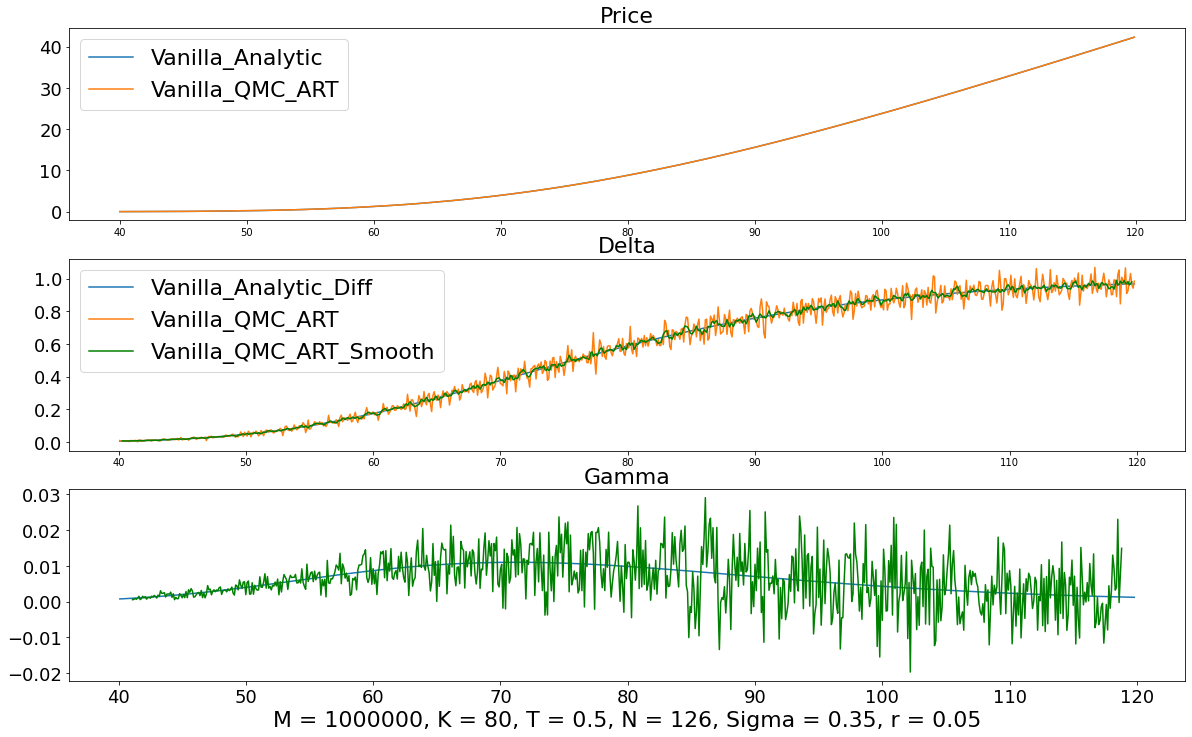

In [22]:
fig = plt.figure(figsize=(20, 12))
ax1 = fig.add_subplot(3, 1, 1)
ax1.plot(vanilla_analytic7, label="Vanilla_Analytic")

ax1.plot(
    qmc_vanilla_art_randomize7, label="Vanilla_QMC_ART",
)
plt.title("Price", fontsize=22)
plt.yticks(fontsize=18)
plt.legend(fontsize=22)

ax2 = fig.add_subplot(3, 1, 2)
ax2.plot(delta(vanilla_analytic7), label="Vanilla_Analytic_Diff")
ax2.plot(
    delta(qmc_vanilla_art_randomize7), label="Vanilla_QMC_ART",
)
ax2.plot(
    delta_smooth, color="g", label="Vanilla_QMC_ART_Smooth",
)
plt.title("Delta", fontsize=22)
plt.yticks(fontsize=18)
plt.legend(fontsize=22)

ax3 = fig.add_subplot(3, 1, 3)
ax3.plot(gamma(vanilla_analytic7))
ax3.plot(gamma_smooth_smooth, color="g")
plt.title("Gamma", fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("M = 1000000, K = 80, T = 0.5, N = 126, Sigma = 0.35, r = 0.05", fontsize=22)

Text(0.5, 0, 'M = 1000000, K = 80, T = 0.5, N = 126, Sigma = 0.35, r = 0.05')

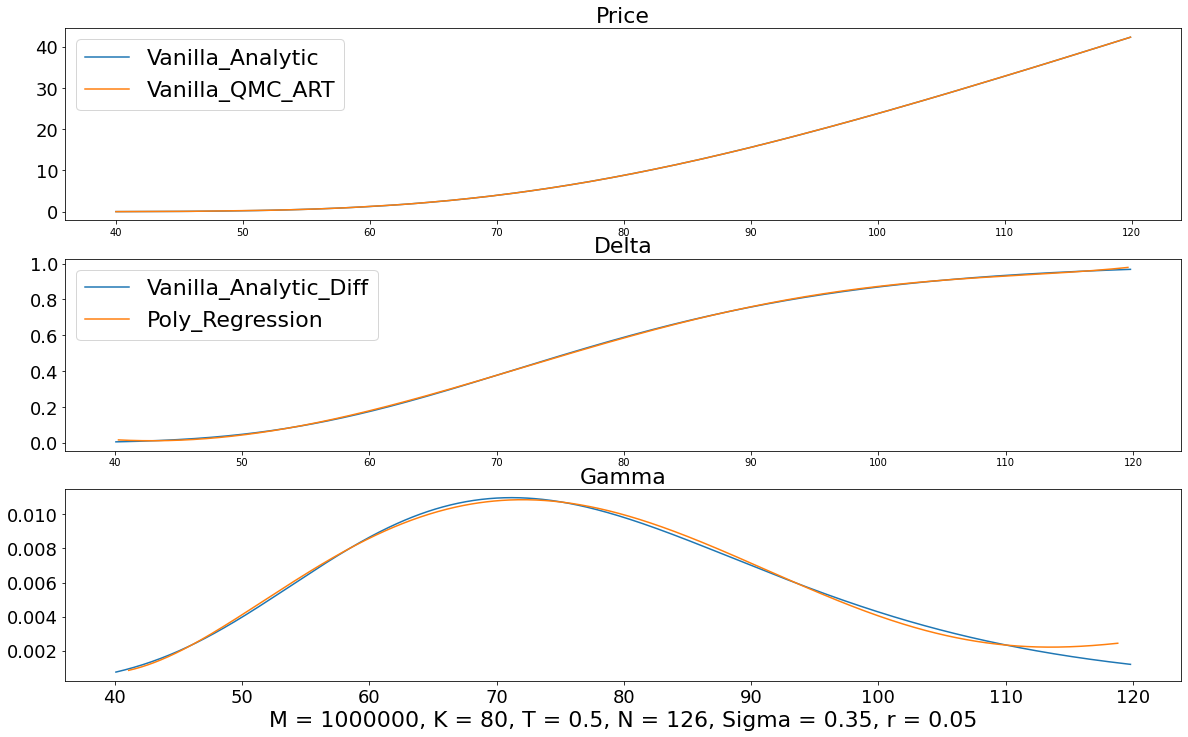

In [23]:
fig = plt.figure(figsize=(20, 12))
ax1 = fig.add_subplot(3, 1, 1)
ax1.plot(vanilla_analytic7, label="Vanilla_Analytic")

ax1.plot(
    qmc_vanilla_art_randomize7, label="Vanilla_QMC_ART",
)
plt.title("Price", fontsize=22)
plt.yticks(fontsize=18)
plt.legend(fontsize=22)

ax2 = fig.add_subplot(3, 1, 2)
ax2.plot(delta(vanilla_analytic7), label="Vanilla_Analytic_Diff")
ax2.plot(polyfit(delta_smooth.iloc[2:-2], 5), label="Poly_Regression")
plt.title("Delta", fontsize=22)
plt.yticks(fontsize=18)
plt.legend(fontsize=22)

ax3 = fig.add_subplot(3, 1, 3)
ax3.plot(gamma(vanilla_analytic7), label="Vanilla_Analytic_Diff")
ax3.plot(polyfit(gamma_smooth_smooth.iloc[10:-10], 5), label="Poly_Regression")
ax3.plot(expfit(gamma_smooth.iloc[5:-5], 6), label="Exp_Regression")
plt.title("Gamma", fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("M = 1000000, K = 80, T = 0.5, N = 126, Sigma = 0.35, r = 0.05", fontsize=22)